<a href="https://colab.research.google.com/github/atik666/attentionModel/blob/cloab/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
pip install -U tensorflow-addons

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd

In [59]:
data = np.load("/content/drive/MyDrive/Colab/encoder/cwtX.npy")
label = np.load("/content/drive/MyDrive/Colab/encoder/y.npy")
data = np.delete(data, np.s_[400:800], axis=0)
data = np.delete(data, np.s_[600:1000], axis=0)
data = np.delete(data, np.s_[800:1200], axis=0)
label = np.concatenate((np.zeros(200), np.zeros(200)+1, np.zeros(200)+2, np.zeros(200)+3), axis=0)
from sklearn.model_selection import train_test_split
x_train, x_rem, y_train, y_rem = train_test_split(data,label, train_size=0.5, stratify=label)
x_val, x_test, y_val, y_test = train_test_split(x_rem,y_rem, test_size=0.5, stratify=y_rem)

In [60]:
label[799]

3.0

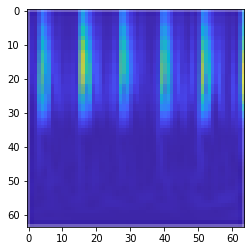

In [61]:
image_x = random.randint(0, len(x_train))

img1 = cv2.cvtColor(x_train[image_x], cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

In [62]:
num_classes = 10
input_shape = (64, 64, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 50
image_size = 64  # We'll resize input images to this size
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [63]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [64]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [65]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [66]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [67]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [68]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data = (x_val, y_val),
        batch_size=batch_size,
        epochs=num_epochs,
    )

    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

vit_classifier = create_vit_classifier()
history, model = run_experiment(vit_classifier)

Epoch 1/50
25/25 [==============================] - 14s 224ms/step - loss: 2.3364 - accuracy: 0.8225 - val_loss: 3.7104e-06 - val_accuracy: 1.0000
Epoch 2/50
25/25 [==============================] - 4s 165ms/step - loss: 1.1577 - accuracy: 0.9550 - val_loss: 7.0810 - val_accuracy: 0.8800
Epoch 3/50
25/25 [==============================] - 4s 166ms/step - loss: 3.7379 - accuracy: 0.9375 - val_loss: 0.3042 - val_accuracy: 0.9750
Epoch 4/50
25/25 [==============================] - 4s 166ms/step - loss: 0.3054 - accuracy: 0.9825 - val_loss: 2.2709e-07 - val_accuracy: 1.0000
Epoch 5/50
25/25 [==============================] - 4s 166ms/step - loss: 0.1835 - accuracy: 0.9950 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/50
25/25 [==============================] - 4s 167ms/step - loss: 0.2801 - accuracy: 0.9925 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/50
25/25 [==============================] - 4s 166ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_ac

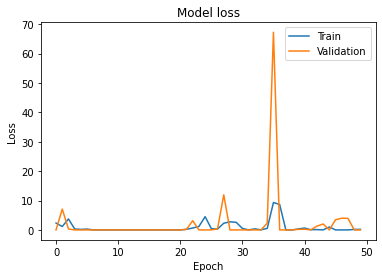

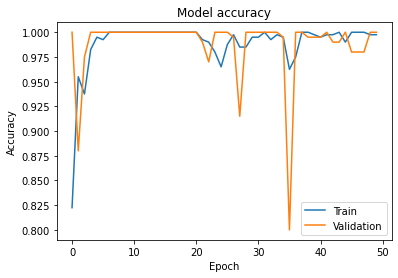

[[50  0  0  0]
 [ 0 50  0  0]
 [ 0  0 50  0]
 [ 0  0  0 50]]
acc :  100.0


In [69]:
def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

def plot_accuracy(acc,val_acc):
  # Plot training & validation accuracy values
  plt.figure()
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.show()

# Plot train vs test loss during training
plot_loss(history.history['loss'], history.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = pred.argmax(axis = 1)
conf = confusion_matrix(y_test, pred)
print(conf)
print('acc : ', np.trace(conf)/np.sum(conf)*100)

In [70]:
x_test1 = np.load("/content/drive/MyDrive/Colab/encoder/load/1X_test.npy")
y_test1 = np.load("/content/drive/MyDrive/Colab/encoder/load/1y_test.npy")
x_test1 = np.delete(x_test1, np.s_[100:200], axis=0)
x_test1 = np.delete(x_test1, np.s_[150:250], axis=0)
x_test1 = np.delete(x_test1, np.s_[200:300], axis=0)
y_test1 = np.concatenate((np.zeros(50), np.zeros(50)+1, np.zeros(50)+2, np.zeros(50)+3), axis=0)
_, accuracy = model.evaluate(x_test1, y_test1)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
pred = model.predict(x_test1)
pred = pred.argmax(axis = 1)
conf = confusion_matrix(y_test1, pred)
print(conf)

7/7 [==============================] - 1s 72ms/step - loss: 17.5490 - accuracy: 0.9250
Test accuracy: 92.5%
[[49  0  0  1]
 [ 0 36  0 14]
 [ 0  0 50  0]
 [ 0  0  0 50]]
